## Data Pre-Processing

In this notebook we will be chipping our images into a smaller size. This will prepare our data for model training.

In [1]:
### Time to import data? Remember how to do the following lines?
import mxnet as mx
import gluoncv as gcv
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Now we will use RecordIO formatted Data Files
train = gcv.data.RecordFileDetection('../CV-Data/train_demo.rec')
val = gcv.data.RecordFileDetection('../CV-Data/val_demo.rec')

Previously we noticed that it was hard to see vehicles from a distance. Since it is hard for us, it probably will be hard
for a computer to notice it as well with all the noise (buildings, background, grass, etc). So lets train on subcrops!!!

In [3]:
def crop_imgs(img,lbl,chip_size=320):#function which crops image
    """
    Normally in this type of function I would have an overlap
     argument so we can accurately label objects on the splits.
    For the sake of time I chose to only do normal cropping.
    Furthermore, someone could chose to store the crops in order to recreate
     the original image.
    """
    
    
    h,w,c = img.shape
    
    #New shape of image (we are just upscaling to a factor of chip_size)
    n_w,n_h = ((w//chip_size) + 1)*chip_size,((h//chip_size) + 1)*chip_size
    img = mx.image.imresize(img,n_w,n_h)
    lbl = gcv.data.transforms.bbox.resize(lbl,(w,h),(n_w,n_h))
    
    #loop over and get chips
    chips = []
    labels = []
    for i in range(h//chip_size-1):
        for j in range(w//chip_size-1):
            crop = (j*chip_size,i*chip_size,chip_size,chip_size)
            chips.append(mx.image.fixed_crop(img,crop[0],crop[1],crop[2],crop[3]))
            labels.append(gcv.data.transforms.bbox.crop(lbl.astype(int),crop))
    return(chips,labels)

In [4]:
img,lbl = train[0]

In [5]:
imgs,labels = crop_imgs(img,lbl,500)

In [6]:
#Classes inside of this dataset
classes = ['Passenger Vehicle',
                'Small Car',
                'Bus',
                'Pickup Truck',
                'Utility Truck',
                'Truck',
                'Cargo Truck',
                'Truck Tractor w/ Box Trailer',
                'Truck Tractor',
                'Trailer',
                'Truck Tractor w/ Flatbed Trailer',
                'Truck Tractor w/ Liquid Tank']

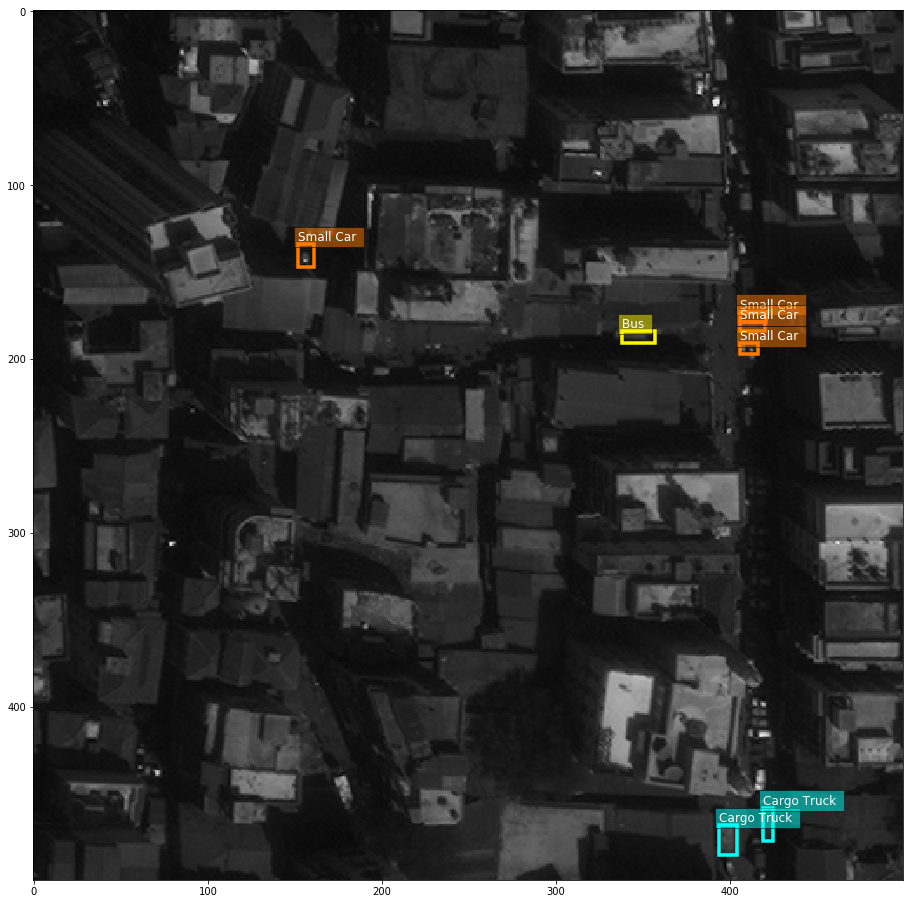

In [7]:
i =2
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(1,1,1)
gcv.utils.viz.plot_bbox(imgs[i],labels[i][:,:-1],labels=labels[i][:,-1],ax=ax,class_names = classes)

In [8]:
def write_line(im_shape, boxes, ids):
    """
    This function is so we can chip our large satellite images for training
    This particular function just transforms the shapes into what is necessary for reciod io
    """
    h, w, c = im_shape
    # for header, we use minimal length 2, plus width and height
    # with A: 4, B: 5, C: width, D: height
    A = 2
    B = 5
    # concat id and bboxes
    labels = np.hstack((ids.reshape(-1, 1), boxes)).astype(int)
    # flatten
    labels = labels.flatten().tolist()
    str_header = [str(x) for x in [A, B]]
    str_labels = [str(x) for x in labels]
    line = '\t'.join(str_header + str_labels) + '\n'
    return line    

In [9]:
#Reload the datasets
train = gcv.data.RecordFileDetection('../CV-Data/train_demo.rec')
val = gcv.data.RecordFileDetection('../CV-Data/val_demo.rec')
size = 208

### Why do we want to work on chips?

This has multiple benefits including speed, but it also allows us to still process the image when we zoom into or blow up the size of the image later on allowing small objects to look larger.

In [11]:
#First we chip the training data
fname_rec = './data/train.rec'
fname_idx = './data/train.idx'
record = mx.recordio.MXIndexedRecordIO(fname_idx,fname_rec,'w')
j = 0
for img,lbl in train:
    imgs,lbls = crop_imgs(img,lbl,size)
    for i in range(len(imgs)):
        if lbls[i].shape[0]>=1:
            l = lbls[i]
            header = write_line(imgs[i].shape,l[:,:-1].astype(int),l[:,-1].astype(int))
            header = mx.recordio.IRHeader(0,header.strip().split('\t'),j,0)
            s = mx.recordio.pack_img(header,imgs[i].asnumpy())
            record.write_idx(j,s)
            j+=1
print('total number of samples is {}'.format(j))
record.close()

total number of samples is 1048


In [12]:
#Now we chip the validation data
fname_rec = './data/val.rec'
fname_idx = './data/val.idx'
record = mx.recordio.MXIndexedRecordIO(fname_idx,fname_rec,'w')
j = 0
for img,lbl in val:
    imgs,lbls = crop_imgs(img,lbl,size)
    for i in range(len(imgs)):
        if lbls[i].shape[0]>=1:
            l = lbls[i]
            header = write_line(imgs[i].shape,l[:,:-1].astype(int),l[:,-1].astype(int))
            header = mx.recordio.IRHeader(0,header.strip().split('\t'),j,0)
            s = mx.recordio.pack_img(header,imgs[i].asnumpy())
            record.write_idx(j,s)
            j+=1
print('total number of samples is {}'.format(j))
record.close()

total number of samples is 364


### Visualizations

This next section will help us visualize the results of our chipping

In [13]:
dta = gcv.data.RecordFileDetection('./data/train.rec',coord_normalized=False)

In [14]:
#How many samples are in our new train data?
print(len(dta))

1048


In [15]:
i = 6

In [16]:
#We will save an image for later to test on.
from PIL import Image
img,lbl = dta[i]
im = Image.fromarray(img.asnumpy())
im.save('./data/test.jpg')
np.save('./data/test-lbls',lbl)

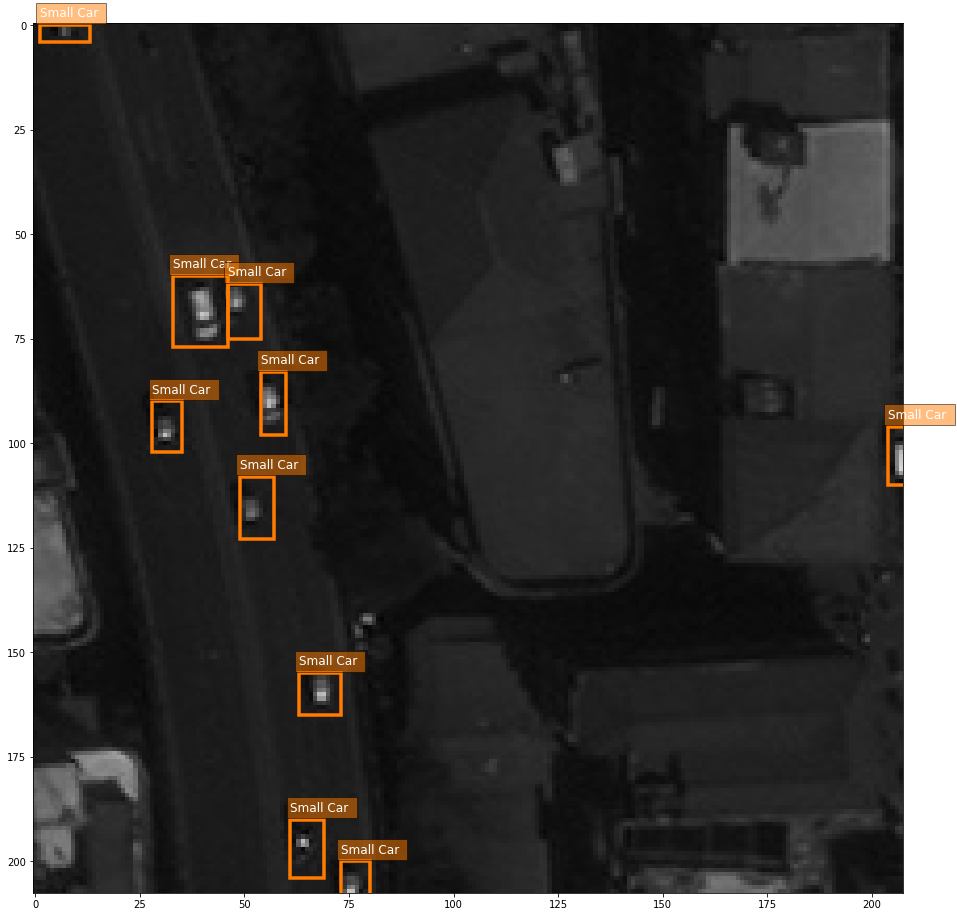

In [17]:
#Here you can view the image we will save for later
img,lbl = dta[i]
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(1,1,1)
gcv.utils.viz.plot_bbox(img,lbl[:,:-1],labels=lbl[:,-1],ax=ax,class_names=classes)
i+=1 #If you want to see more chipped images just re run this cell

In [18]:
#And now we will do everything for the validation data
dta = gcv.data.RecordFileDetection('./data/val.rec',coord_normalized=False)

In [19]:
print(len(dta))

364


In [20]:
i = 0

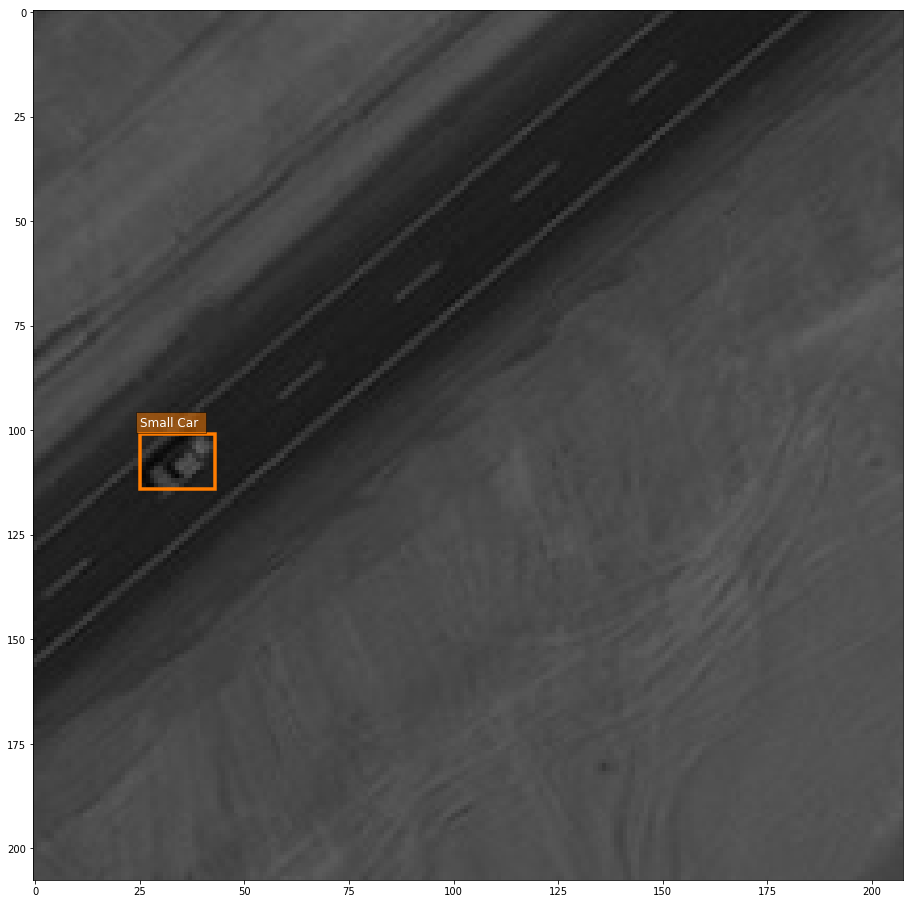

In [21]:
img,lbl = dta[i]
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(1,1,1)
gcv.utils.viz.plot_bbox(img,lbl[:,:-1],labels=lbl[:,-1],ax=ax,class_names=classes)
i+=1